# Modeling 
***

## Some info on dataframes from [Spotify API website](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-features)

### Content
The "data.csv" file contains more than 170.000 songs collected from Spotify Web API, and also you can find data grouped by artist, year, or genre in the data section.

### Primary:
- id 
    - Id of track generated by Spotify
### Numerical:
- acousticness (Ranges from 0 to 1): The positiveness of the track
    - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- danceability (Ranges from 0 to 1)
    - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- energy (Ranges from 0 to 1)
    - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- duration_ms (Integer typically ranging from 200k to 300k)
    - The duration of the track in milliseconds.
- instrumentalness (Ranges from 0 to 1)
    - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- valence (Ranges from 0 to 1)
    - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
- popularity (Ranges from 0 to 100)
    - The popularity of the album. The value will be between 0 and 100, with 100 being the most popular. The popularity is calculated from the popularity of the album’s individual tracks.
- tempo (Float typically ranging from 50 to 150)
    - The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- liveness (Ranges from 0 to 1)
    - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- loudness (Float typically ranging from -60 to 0)
    - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
- speechiness (Ranges from 0 to 1)
    - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- year 
    - Ranges from 1921 to 2020
### Dummy:
- mode (0 = Minor, 1 = Major)
    - Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- explicit (0 = No explicit content, 1 = Explicit content)
### Categorical:
- key (All keys on octave encoded as values ranging from 0 to 11
    - The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
- artists (List of artists mentioned)
    - The artists of the album. Each artist object includes a link in href to more detailed information about the artist.
- release_date (Date of release mostly in yyyy-mm-dd format, however precision of date may vary)
    - The date the album was first released, for example “1981-12-15”. Depending on the precision, it might be shown as “1981” or “1981-12”.
- name 
    - The name of the album. In case of an album takedown, the value may be an empty string.

In [1]:
# Import necessary libraries/packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from matplotlib import dates

In [2]:
# Load dataset and ceate pd dataframes
df = pd.read_csv('../DATA/data.csv', index_col='year', parse_dates=True)

In [3]:
df.head()

,valence,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
year,,,,,,,,,,,,,,,,,,
1921-01-01,0.0594,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1921-01-01,0.9630,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
1921-01-01,0.0394,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
1921-01-01,0.1650,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
1921-01-01,0.2530,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [4]:
df.tail()

,valence,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
year,,,,,,,,,,,,,,,,,,
2020-01-01,0.608,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
2020-01-01,0.734,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
2020-01-01,0.637,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
2020-01-01,0.195,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055
2020-01-01,0.642,0.13200,"['KEVVO', 'J Balvin']",0.856,189507,0.721,1,7HmnJHfs0BkFzX4x8j0hkl,0.004710,7,0.1820,-4.928,1,Billetes Azules (with J Balvin),74,2020-10-16,0.1080,94.991


In [5]:
# Remove unnecessary columns
df = df.drop(labels = ['mode', 'release_date', 'explicit'], axis=1)
df.shape

(170653, 15)

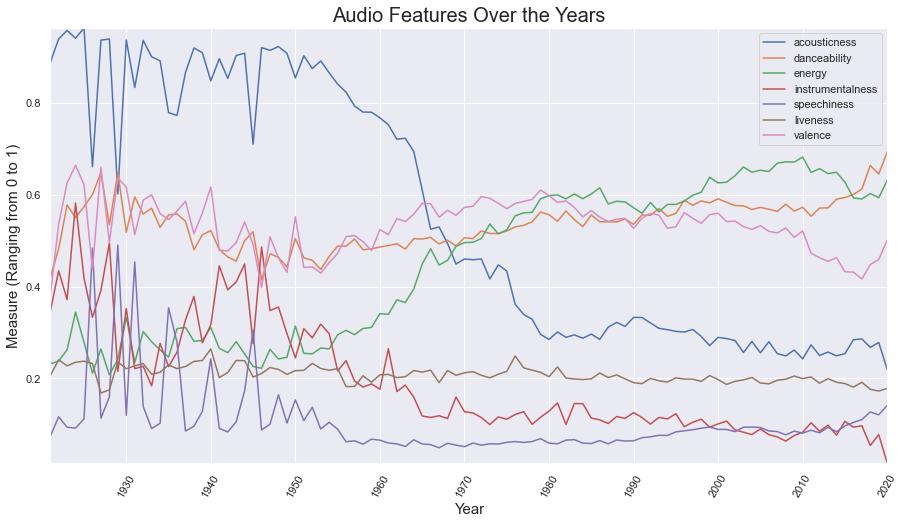

In [6]:
plt.figure(figsize=(15, 8))
sns.set(style="darkgrid") 
columns = ["acousticness","danceability","energy","instrumentalness","speechiness","liveness","valence"]

for col in columns:
    x = df.groupby("year")[col].mean()
    ax = sns.lineplot(x=x.index,y=x,label=col, palette=("Dark2"))
    
ax.set_title('Audio Features Over the Years', fontsize=20)
ax.set_ylabel('Measure (Ranging from 0 to 1)', fontsize=15)
ax.set_xlabel('Year', fontsize=15)

plt.xticks(rotation = 60)
plt.autoscale(tight=True)
plt.show()

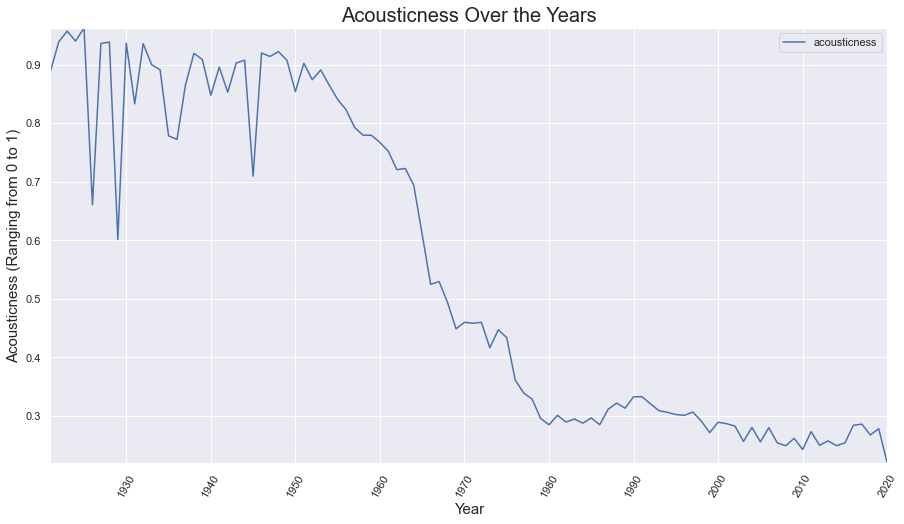

In [7]:
plt.figure(figsize=(15, 8))
sns.set(style="darkgrid") 
columns = ["acousticness"]

for col in columns:
    x = df.groupby("year")[col].mean()
    ax = sns.lineplot(x=x.index,y=x,label=col, palette=("Dark2"))
    
ax.set_title('Acousticness Over the Years', fontsize=20)
ax.set_ylabel('Acousticness (Ranging from 0 to 1)', fontsize=15)
ax.set_xlabel('Year', fontsize=15)

plt.xticks(rotation = 60)
plt.autoscale(tight=True)
plt.show()

Acouticness has gone down over the years

## Predicting Acoustic Popularity

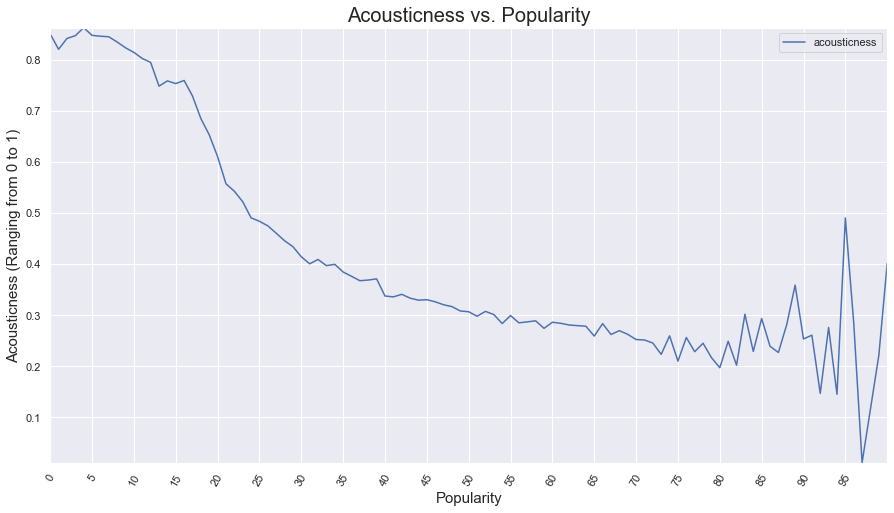

In [9]:
plt.figure(figsize=(15, 8))
sns.set(style="darkgrid") 
columns = ["acousticness"]

for col in columns:
    x = df.groupby("popularity")[col].mean()
    ax = sns.lineplot(x=x.index,y=x,label=col, palette=("Dark2"))
    
ax.set_title('Acousticness vs. Popularity', fontsize=20)
ax.set_ylabel('Acousticness (Ranging from 0 to 1)', fontsize=15)
ax.set_xlabel('Popularity', fontsize=15)

plt.xticks(rotation = 60)
plt.xticks(np.arange(0, 100, 5))
plt.autoscale(tight=True)
plt.show()

In [10]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(df['acousticness'])

Augmented Dickey-Fuller Test: 
